1. Install packages.

pip= python import package

In [ ]:
!pip install torch torchvision pandas scikit-learn matplotlib seaborn

2. import libraries

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix,classification_report,roc_curve,roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

3. Load dataset

In [ ]:
data_path='/content/diabetes.csv'
df=pd.read_csv(data_path)
print(df.head())

   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  


4. Data Preprocessing

In [ ]:
X=df.drop('Outcome', axis=1).values
y=df['Outcome'].values

5. Split train and test dataset.(Train/Test Split)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split (X, y, test_size=0.2, random_state=42)

Standardize Features

In [ ]:
scaler=StandardScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

Convert Pytorch tensors

In [ ]:
X_train=torch.tensor(X_train, dtype=torch.float32)
X_test=torch.tensor(X_test, dtype=torch.float32).unsqueeze(1)
y_train=torch.tensor(y_train, dtype=torch.float32)
y_test=torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

create Dataset and Dataloader

In [ ]:
train_dataset=TensorDataset(X_train, y_train)
test_dataset=TensorDataset(X_test, y_test)
train_loader=DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader=DataLoader(test_dataset,batch_size=32, shuffle=False)

Define Model

In [ ]:
class FeedForwardNN(nn.Module):
    def __init__(self, input_size):  # Add input_size as an argument
        super(FeedForwardNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

create model instance and inspect

In [ ]:
input_size = X_train.shape[1]
model = FeedForwardNN(input_size)
print(model)

FeedForwardNN(
  (fc1): Linear(in_features=8, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=1, bias=True)
)


loss function and optimizer

In [ ]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

Training Loop

In [ ]:
num_epochs = 50
loss_values = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for inputs, labels in train_loader:
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)

        # ▼▼▼ THIS IS THE FIX ▼▼▼
        # Reshape labels to [batch_size, 1] and convert to float
        labels = labels.view(-1, 1).float()

        # Calculate loss
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(train_dataset)
    loss_values.append(epoch_loss)
    print(f'Epoch {epoch+1}/{num_epochs} Loss: {epoch_loss:.4f}')

Epoch 1/50 Loss: 0.6647
Epoch 2/50 Loss: 0.5962
Epoch 3/50 Loss: 0.5380
Epoch 4/50 Loss: 0.4997
Epoch 5/50 Loss: 0.4800
Epoch 6/50 Loss: 0.4680
Epoch 7/50 Loss: 0.4574
Epoch 8/50 Loss: 0.4531
Epoch 9/50 Loss: 0.4465
Epoch 10/50 Loss: 0.4406
Epoch 11/50 Loss: 0.4394
Epoch 12/50 Loss: 0.4352
Epoch 13/50 Loss: 0.4329
Epoch 14/50 Loss: 0.4301
Epoch 15/50 Loss: 0.4270
Epoch 16/50 Loss: 0.4239
Epoch 17/50 Loss: 0.4222
Epoch 18/50 Loss: 0.4250
Epoch 19/50 Loss: 0.4190
Epoch 20/50 Loss: 0.4189
Epoch 21/50 Loss: 0.4137
Epoch 22/50 Loss: 0.4117
Epoch 23/50 Loss: 0.4094
Epoch 24/50 Loss: 0.4084
Epoch 25/50 Loss: 0.4051
Epoch 26/50 Loss: 0.4064
Epoch 27/50 Loss: 0.4043
Epoch 28/50 Loss: 0.4021
Epoch 29/50 Loss: 0.4006
Epoch 30/50 Loss: 0.4023
Epoch 31/50 Loss: 0.3965
Epoch 32/50 Loss: 0.3968
Epoch 33/50 Loss: 0.3958
Epoch 34/50 Loss: 0.3936
Epoch 35/50 Loss: 0.3920
Epoch 36/50 Loss: 0.3885
Epoch 37/50 Loss: 0.3877
Epoch 38/50 Loss: 0.3856
Epoch 39/50 Loss: 0.3840
Epoch 40/50 Loss: 0.3822
Epoch 41/

evaluation

In [ ]:
model.eval()
y_true=[]
y_pred=[]
y_scores=[]

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs=model(inputs)
        probs=torch.sigmoid(outputs)
        predicted=(probs>0.5).float()
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())
        y_scores.extend(probs.cpu().numpy())
    y_true=np.array(y_true).flatten()
    y_pred=np.array(y_pred).flatten()
    y_scores=np.array(y_scores).flatten()

confusion matrix plot

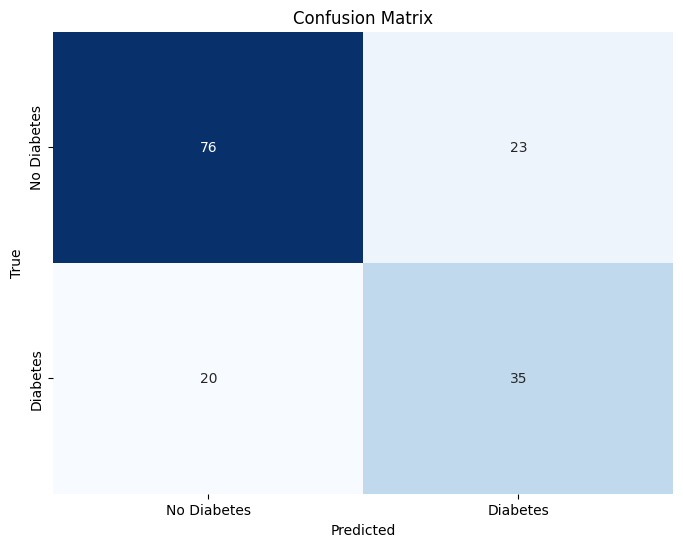


Classification Report
              precision    recall  f1-score   support

 No Diabetes       0.79      0.77      0.78        99
    Diabetes       0.60      0.64      0.62        55

    accuracy                           0.72       154
   macro avg       0.70      0.70      0.70       154
weighted avg       0.72      0.72      0.72       154



In [ ]:
cm=confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,  xticklabels=['No Diabetes', 'Diabetes'], yticklabels=['No Diabetes', 'Diabetes'])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

print("\nClassification Report")
print(classification_report(y_true, y_pred, target_names=['No Diabetes', 'Diabetes']))

ROC CURVE and AUC

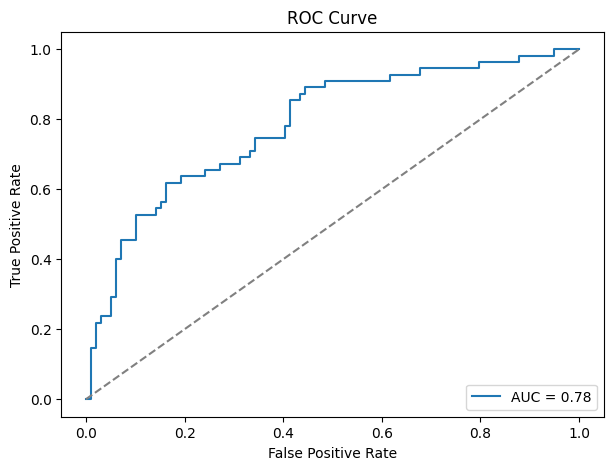

In [ ]:
fpr, tpr, thresholds = roc_curve(y_true, y_scores)
auc_score = roc_auc_score(y_true, y_scores)

plt.figure(figsize=(7,5))
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.2f}")
plt.plot([0,1],[0,1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()












Save the model

In [ ]:
torch.save({'model_state_dict': model.state_dict(),'scaler':scaler}, "diabetes_model_with_scaler.pth")
print("\nModel saved as diabetes_model_with_scaler.pth")


Model saved as diabetes_model_with_scaler.pth


load the model(for inference later)

In [ ]:
loaded_model = FeedForwardNN(input_size)
loaded_model.load_state_dict(torch.load("diabetes_model_with_scaler.pth", weights_only=False)['model_state_dict'])
loaded_model.eval()
print("Model loaded successfully")

Model loaded successfully


example

In [ ]:
with torch.no_grad():
    output = loaded_model(X_test[0].unsqueeze(0))
    prob = torch.sigmoid(output).item()
    print(f"Sample prediction: {prob}")

Sample prediction: 0.40096408128738403


In [ ]:
from google.colab import files
files.download("//content/diabetes_model_with_scaler.pth")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving diabetes_model_with_scaler.pth to diabetes_model_with_scaler (1).pth


Install dependencies

In [ ]:
!pip install torch torchvision gradio scikit-learn

1. Imports

In [ ]:
import torch
import torch.nn as nn
import gradio as gr

2. Define the Model

In [ ]:
class FeedforwardNN(nn.Module):
    def __init__(self, input_size):
        super(FeedforwardNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

3.Load trained model + scaler

In [ ]:
input_size =8
model = FeedforwardNN(input_size)

checkpoint = torch.load('diabetes_model_with_scaler.pth', map_location=torch.device('cpu'), weights_only=False)
model.load_state_dict(checkpoint['model_state_dict'])
scaler = checkpoint['scaler']

4.Prediction function

In [ ]:
def predict_diabetes(Pregnancies, Glucose, BloodPressure, SkinThickness,
                     Insulin, BMI, DPF, Age):
    # 1. Prepare input as 2D numpy array for the scaler
    features = np.array([[Pregnancies, Glucose, BloodPressure, SkinThickness,
                        Insulin, BMI, DPF, Age]])

    # 2. Scale the features
    features_scaled = scaler.transform(features)

    # 3. Convert to torch tensor
    sample = torch.tensor(features_scaled, dtype=torch.float32)

    # 4. Model inference
    with torch.no_grad():
        output = model(sample)
        prob = torch.sigmoid(output).item()
        pred = 1 if prob > 0.5 else 0

    result = "Diabetic" if pred == 1 else "Not Diabetic"
    return f"Prediction: {result} (Probability: {prob:.2f})"

5.Gradio interface

In [ ]:
inputs = [
    gr.Number(label="Pregnancies"),
    gr.Number(label="Glucose"),
    gr.Number(label="BloodPressure"),
    gr.Number(label="SkinThickness"),
    gr.Number(label="Insulin"),
    gr.Number(label="BMI"),
    gr.Number(label="DiabetesPedigreeFunction"),
    gr.Number(label="Age"),
]

iface = gr.Interface(
    fn=predict_diabetes,
    inputs=inputs,
    outputs="text",
    title="Diabetes Prediction",
    description="Enter patient details and predict diabetes risk."
)

In [ ]:
iface.launch(debug=True)

It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://ad9a241407652a073b.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
